**NFL Matchup Testing**

This contains our successful, and notable unsuccessful, work

# Load spark and connect to drive


In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.2.0/spark-3.2.0-bin-hadoop3.2.tgz
!tar xf spark-3.2.0-bin-hadoop3.2.tgz
!pip install -q findspark

In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "spark-3.2.0-bin-hadoop3.2"
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
sc = spark.sparkContext
sc

<SparkContext master=local[*] appName=pyspark-shell>

In [3]:
# upload file
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Team performance metrics (non-scoring)

In [4]:
# read weekly team data
path = '/content/drive/MyDrive/Cloud NFL/NFLstats2012-2023/weekly_team_data.csv'
df = spark.read.csv(path, header=True, inferSchema=True)

In [5]:
# create name for table
df.createOrReplaceTempView("NFL")
df.show(5)

+----+------+----+-----------+------------+---------+-------------------+------------------+------------+---------+---------+---------+------+-----------+-------+---------+-----------+----------------+--------------+-------------+-------------+---------------+---------+-------------+-------+------------+-------+----------+---------------+-----------------+------------+-----------+----------------+----------------+--------------+-----------+-------------+------+----------+---------------+----+------+----+-------+----+
|team|season|week|total_snaps|yards_gained|touchdown|extra_point_attempt|field_goal_attempt|total_points|td_points|xp_points|fg_points|fumble|fumble_lost|shotgun|no_huddle|qb_dropback|pass_snaps_count|pass_snaps_pct|pass_attempts|complete_pass|incomplete_pass|air_yards|passing_yards|pass_td|interception|targets|receptions|receiving_yards|yards_after_catch|receiving_td|pass_fumble|pass_fumble_lost|rush_snaps_count|rush_snaps_pct|qb_scramble|rushing_yards|run_td|run_fumble|r

In [6]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator

Choosing which features to include and not include was a difficult process, especially for avoiding overfitting and multicolinearity.  For example, these are all available statistics: yards gained, rushing yards, passing yards, yards after catch.  Notice that [yards gained = rushing yars + passing yards + yards after catch] for the most part.  Not all of these yards are made equal either.  Additionally, we avoided things that would obviously give away the answer like touchdowns scored, field goals kicked, etc.

We tried to avoid using too many overlapping variables, and included below are the most relevant variables that made a stastical impact on the training data.

In [7]:
assembler = VectorAssembler(inputCols=["yards_gained", "pass_attempts", "shotgun", "interception",
                                       "rush_snaps_count", "rushing_yards", "total_snaps", "fumble",
                                       "qb_scramble"], outputCol="features")
train_data, test_data = df.randomSplit([0.8, 0.2], seed=2)
lr = LinearRegression(featuresCol="features", labelCol="total_points", solver="normal")
pipeline = Pipeline(stages=[assembler, lr])
model = pipeline.fit(train_data)
predictions = model.transform(test_data)

### Evaluation and Performance

In [8]:
evaluator = RegressionEvaluator(labelCol="total_points", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE): {rmse}")

Root Mean Squared Error (RMSE): 6.474616313176618


RMSE is the average deviation of the model's predicted values to the actual values.  A way to interpret this in our context is that the RMSE value is about how many points our model was off by.  An RMSE of less than 6-7 means that our model was, on average, within a touchdown of estimating the total points.

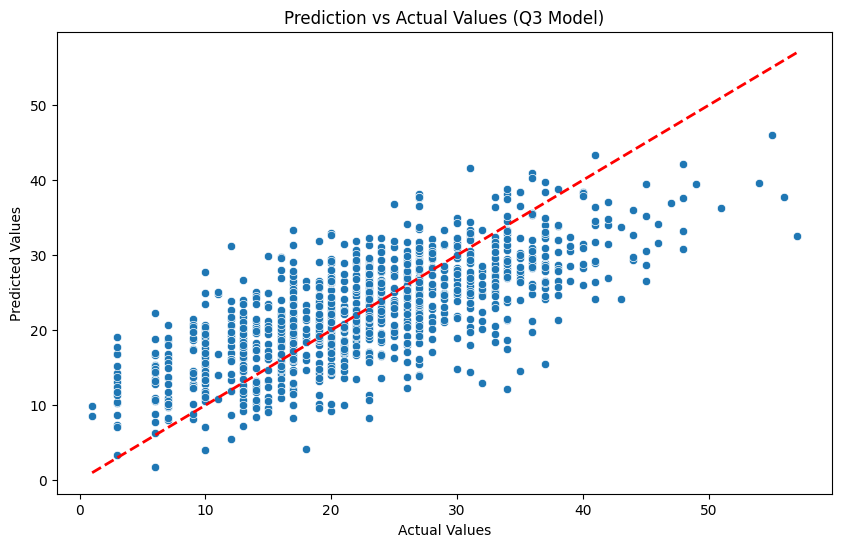

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

tpm = predictions.select("prediction", "total_points").toPandas()
tpm.rename(columns={"prediction": "Predicted", "total_points": "Actual"}, inplace=True)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=tpm['Actual'], y=tpm['Predicted'])
plt.plot(
    [tpm['Actual'].min(), tpm['Actual'].max()],
    [tpm['Actual'].min(), tpm['Actual'].max()],
    'r--', lw=2
)
plt.title('Prediction vs Actual Values (Q3 Model)')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

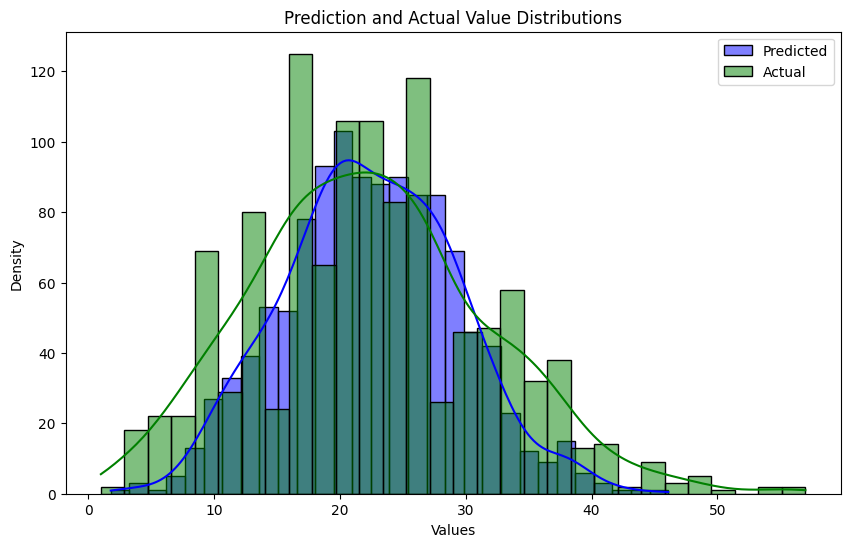

In [10]:
plt.figure(figsize=(10, 6))
sns.histplot(tpm['Predicted'], kde=True, color='blue', label='Predicted', bins=30)
sns.histplot(tpm['Actual'], kde=True, color='green', label='Actual', bins=30)
plt.title('Prediction and Actual Value Distributions')
plt.xlabel('Values')
plt.ylabel('Density')
plt.legend()
plt.show()

In [11]:
# a look into the variables used in the model
lr_model = model.stages[-1]

summary = lr_model.summary
coefficients = lr_model.coefficients
standard_errors = summary.coefficientStandardErrors
t_values = summary.tValues
p_values = summary.pValues

# print statistics
for i in range(len(coefficients)):
    print(f"Feature {i + 1}:")
    print(f"  Coefficient: {coefficients[i]}")
    print(f"  Standard Error: {standard_errors[i]}")
    print(f"  t-value: {t_values[i]}")
    print(f"  p-value: {p_values[i]}")

Feature 1:
  Coefficient: 0.04139480030047167
  Standard Error: 0.0008343346669232801
  t-value: 49.61414398986979
  p-value: 0.0
Feature 2:
  Coefficient: 0.149141214730093
  Standard Error: 0.061500838469307054
  t-value: 2.4250273401479596
  p-value: 0.015342377122180562
Feature 3:
  Coefficient: -0.020219157362844777
  Standard Error: 0.009645996430728462
  t-value: -2.0961191006078193
  p-value: 0.036121698049597306
Feature 4:
  Coefficient: -0.7534787598468816
  Standard Error: 0.11844606650242567
  t-value: -6.361365827470944
  p-value: 2.1777557535074266e-10
Feature 5:
  Coefficient: 0.472501623154223
  Standard Error: 0.05947802202701692
  t-value: 7.944138137942732
  p-value: 2.4424906541753444e-15
Feature 6:
  Coefficient: 0.025775655345686446
  Standard Error: 0.0029558465664793203
  t-value: 8.720227781101498
  p-value: 0.0
Feature 7:
  Coefficient: -0.3585633575450772
  Standard Error: 0.058894649038698975
  t-value: -6.088216219939938
  p-value: 1.2268837057405335e-09
Fe

# Score prediction based on prior scores

In [12]:
# read historical play by play data
path = '/content/drive/MyDrive/Cloud NFL/NFL Play by Play 2009-2018 (v5).csv'
df = spark.read.csv(path, header=True, inferSchema=True)

In [13]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import GeneralizedLinearRegression
from pyspark.sql.functions import col, when, abs
from pyspark.sql import functions as F
from pyspark.sql.functions import when
from pyspark.ml.feature import PolynomialExpansion, StandardScaler

## Format DF

Note: we do include separation of home teams and away teams.  Home teams have a distinct advantage, and with how little effort it is to add, we thought it would be an unecessary error to exclude.

In [14]:
# reduces size of df to only have needed columns
pts = df.select('game_id', 'home_team', 'away_team', 'game_date', 'qtr', 'total_home_score', 'total_away_score')
pts.createOrReplaceTempView("NFL")

In [15]:
# gets total score for each quarter

# home team total scores
quarters = spark.sql("\
SELECT `game_id`, `qtr`, MAX(total_home_score) as score \
FROM NFL \
GROUP BY `game_id`, `qtr` \
")
# away team total scores
quarters_away = spark.sql("\
SELECT `game_id`, `qtr`, MAX(total_away_score) as score \
FROM NFL \
GROUP BY `game_id`, `qtr` \
")

In [16]:
# pivots the quarter data so each row is a single game with columns of the score
# by each quarter

# home pivot
df_pivot = (
    quarters.groupBy('game_id')
    .pivot("qtr", ['1','2','3','4'])  # Specify the unique values of 'time' if known
    .agg(F.first("score"))  # Aggregate by taking the first score for each 'time'
)
# away pivot
df_pivot_away = (
    quarters_away.groupBy('game_id')
    .pivot("qtr", ['1','2','3','4'])  # Specify the unique values of 'time' if known
    .agg(F.first("score"))  # Aggregate by taking the first score for each 'time'
)

In [17]:
# create column "Home", home = 1, away = 0

from pyspark.sql.functions import lit
df_pivot = df_pivot.withColumn("Home", lit(1))
df_pivot_away = df_pivot_away.withColumn("Home", lit(0))

df_new = df_pivot.union(df_pivot_away)

In [18]:
# making new feature columns

# creates weights for the scores
df_new = df_new.withColumn("weighted_1", col("1") * 0.5)
df_new = df_new.withColumn("weighted_2", col("2") * 1.0)
df_new = df_new.withColumn("weighted_3", col("3") * 1.5)

# gets individual points scored in each quarter
df_new = df_new.withColumn("q2pts", col("2") - col("1"))
df_new = df_new.withColumn("q3pts", col("3") - col("2"))

# creates interaction effects
df_new = df_new.withColumn("interaction_1_2", col("1") * col("2"))
df_new = df_new.withColumn("interaction_2_3", col("2") * col("3"))
df_new = df_new.withColumn("interaction_1_3", col("1") * col("3"))

In [19]:
# score must be above 0 for model to work
# also doubles as removing outliers
df_new = df_new.filter(col("4") > 0)

## Q1 Model

In [20]:
''' QUARTER 1 '''

assembler = VectorAssembler(
    inputCols=[
        "1", "Home"
    ],
    outputCol="features"
)


poly_expansion = PolynomialExpansion(inputCol="features", outputCol="poly_features", degree=2)
scaler = StandardScaler(inputCol="poly_features", outputCol="scaled_features", withStd=True, withMean=False)
glr = GeneralizedLinearRegression(
    featuresCol="scaled_features",
    labelCol="4",
    family="gaussian",
    link="log",
    maxIter=50,         #Increase iterations for better convergence#
    regParam=0.1        #Add regularization to reduce overfitting#
)

pipeline_glr = Pipeline(stages=[assembler, poly_expansion, scaler, glr])
train_data, test_data = df_new.randomSplit([0.8, 0.2], seed=42)

model_glr_q1 = pipeline_glr.fit(train_data)
predictions_glr_q1 = model_glr_q1.transform(test_data)

In [ ]:
#model_path = "/content/drive/MyDrive/Cloud NFL/Q1Pipeline"
#model_glr_q1.save(model_path)

### Evaluation and Performance

In [21]:
#Evaluate the Model
evaluator = RegressionEvaluator(labelCol="4", predictionCol="prediction", metricName="rmse")
rmse_glr = evaluator.evaluate(predictions_glr_q1)

print(f"Enhanced Generalized Linear Regression RMSE: {rmse_glr}")

Enhanced Generalized Linear Regression RMSE: 8.361293621958868


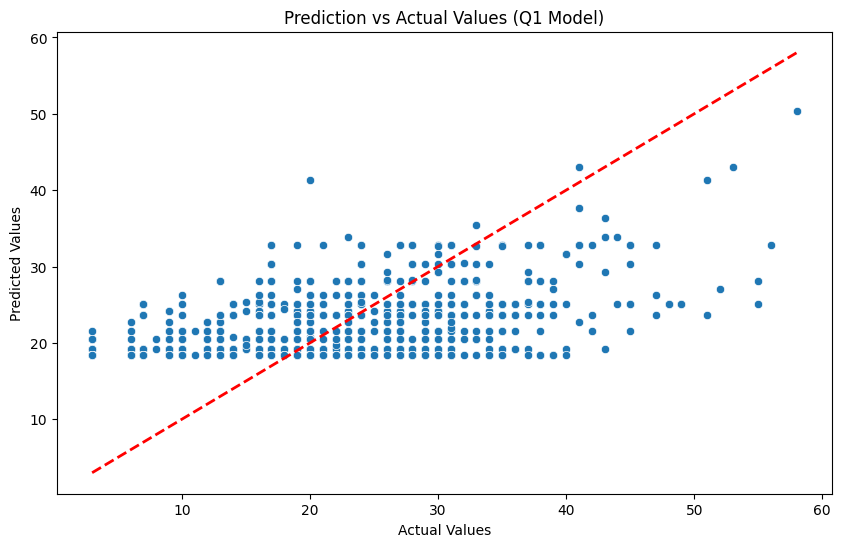

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Replace `predictions` with the dataset for Quarter 3
q1_data = predictions_glr_q1.select("prediction", "4").toPandas()
q1_data.rename(columns={"prediction": "Predicted", "4": "Actual"}, inplace=True)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=q1_data['Actual'], y=q1_data['Predicted'])
plt.plot(
    [q1_data['Actual'].min(), q1_data['Actual'].max()],
    [q1_data['Actual'].min(), q1_data['Actual'].max()],
    'r--', lw=2
)
plt.title('Prediction vs Actual Values (Q1 Model)')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

Clearly this model has a lot of difficulty in predicting low value games.  It tends to think everyone will score a bit of points; heavily discrediting low point scorers and large point scorers.

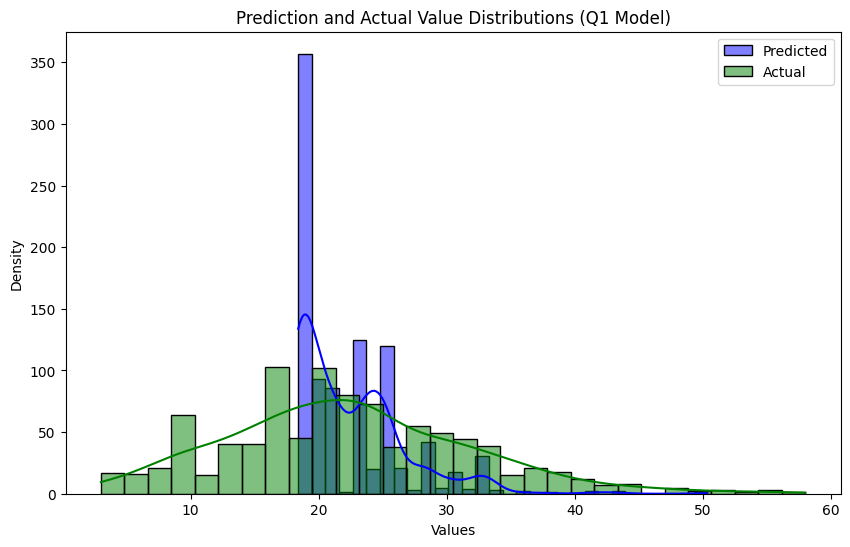

In [23]:
plt.figure(figsize=(10, 6))
sns.histplot(q1_data['Predicted'], kde=True, color='blue', label='Predicted', bins=30)
sns.histplot(q1_data['Actual'], kde=True, color='green', label='Actual', bins=30)
plt.title('Prediction and Actual Value Distributions (Q1 Model)')
plt.xlabel('Values')
plt.ylabel('Density')
plt.legend()
plt.show()

We see this again, instead of having a desired normal-ish distribution, we see... that.

## Q2 Models

In [24]:
''' QUARTER 2 '''

assembler = VectorAssembler(
    inputCols=[
        "1", "q2pts", "2", "weighted_1", "weighted_2",
        "interaction_1_2", "Home"
    ],
    outputCol="features"
)

poly_expansion = PolynomialExpansion(inputCol="features", outputCol="poly_features", degree=2)
scaler = StandardScaler(inputCol="poly_features", outputCol="scaled_features", withStd=True, withMean=False)
glr = GeneralizedLinearRegression(
    featuresCol="scaled_features",
    labelCol="4",
    family="gaussian",
    link="log",
    maxIter=50,         #Increase iterations for better convergence#
    regParam=0.1        #Add regularization to reduce overfitting#
)

pipeline_glr = Pipeline(stages=[assembler, poly_expansion, scaler, glr])
train_data, test_data = df_new.randomSplit([0.8, 0.2], seed=42)

model_glr_q2 = pipeline_glr.fit(train_data)
predictions_glr_q2 = model_glr_q2.transform(test_data)

In [ ]:
#model_path = "/content/drive/MyDrive/Cloud NFL/Q2Pipeline"
#model_glr_q2.save(model_path)

In [25]:
# Evaluate the Model
evaluator = RegressionEvaluator(labelCol="4", predictionCol="prediction", metricName="rmse")
rmse_glr = evaluator.evaluate(predictions_glr_q2)

print(f"Enhanced Generalized Linear Regression RMSE: {rmse_glr}")

Enhanced Generalized Linear Regression RMSE: 6.865225751429552


In [26]:
''' QUARTER 2 alternative '''

assembler = VectorAssembler(
    inputCols=[
        "1", "q2pts", "interaction_1_2", "Home"
    ],
    outputCol="features"
)

poly_expansion = PolynomialExpansion(inputCol="features", outputCol="poly_features", degree=2)
scaler = StandardScaler(inputCol="poly_features", outputCol="scaled_features", withStd=True, withMean=False)
glr = GeneralizedLinearRegression(
    featuresCol="scaled_features",
    labelCol="4",
    family="gaussian",
    link="log",
    maxIter=50,         #Increase iterations for better convergence#
    regParam=0.1        #Add regularization to reduce overfitting#
)

pipeline_glr = Pipeline(stages=[assembler, poly_expansion, scaler, glr])
train_data, test_data = df_new.randomSplit([0.8, 0.2], seed=42)

model_glr_q2_alt = pipeline_glr.fit(train_data)
predictions_glr_q2_alt = model_glr_q2_alt.transform(test_data)

In [27]:
# Evaluate the Model
evaluator = RegressionEvaluator(labelCol="4", predictionCol="prediction", metricName="rmse")
rmse_glr = evaluator.evaluate(predictions_glr_q2_alt)

print(f"Enhanced Generalized Linear Regression RMSE: {rmse_glr}")

Enhanced Generalized Linear Regression RMSE: 6.893662043237555


### Performance

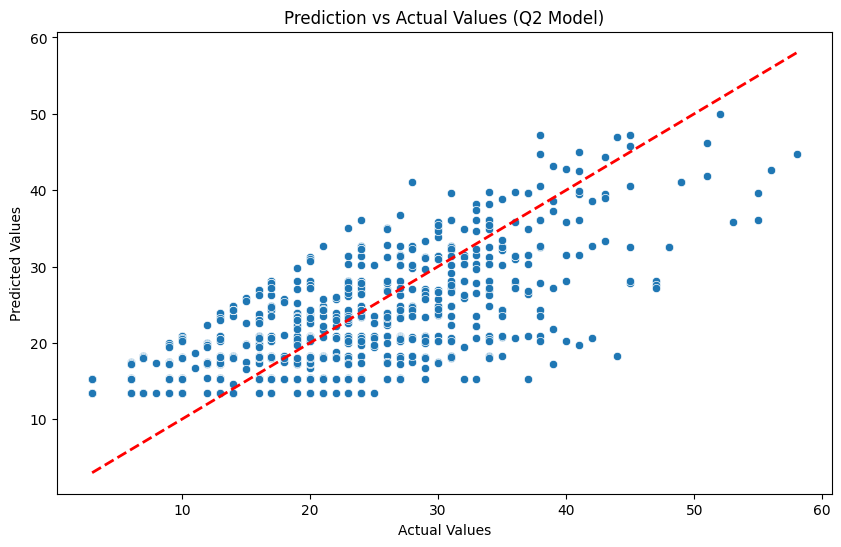

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# Replace `predictions` with the dataset for Quarter 3
q2_data = predictions_glr_q2.select("prediction", "4").toPandas()
q2_data.rename(columns={"prediction": "Predicted", "4": "Actual"}, inplace=True)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=q2_data['Actual'], y=q2_data['Predicted'])
plt.plot(
    [q2_data['Actual'].min(), q2_data['Actual'].max()],
    [q2_data['Actual'].min(), q2_data['Actual'].max()],
    'r--', lw=2
)
plt.title('Prediction vs Actual Values (Q2 Model)')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

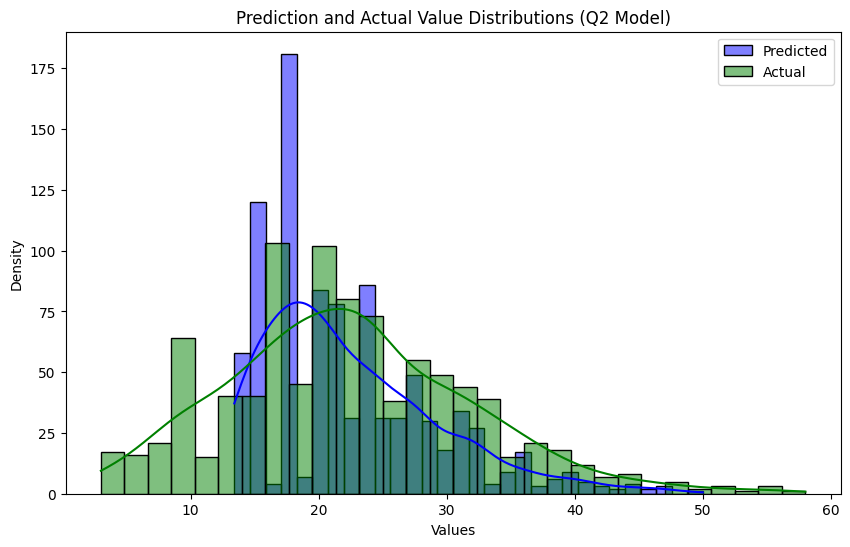

In [29]:
plt.figure(figsize=(10, 6))
sns.histplot(q2_data['Predicted'], kde=True, color='blue', label='Predicted', bins=30)
sns.histplot(q2_data['Actual'], kde=True, color='green', label='Actual', bins=30)
plt.title('Prediction and Actual Value Distributions (Q2 Model)')
plt.xlabel('Values')
plt.ylabel('Density')
plt.legend()
plt.show()

As we can see again, our model does a pretty poor job at predicting low point value games and groups these all into moderate point scoring games.  However, we can start seeing the tail end of the distribution doing significantly better at meeting those higher values, even if the model still undervalues it.

## Q3 Models


In [30]:
''' QUARTER 3 '''

assembler = VectorAssembler(
    inputCols=[
        "1", "q2pts", "q3pts", "3", "weighted_1", "weighted_2", "weighted_3",
        "interaction_1_2", "interaction_2_3", "interaction_1_3", "Home"
    ],
    outputCol="features"
)

poly_expansion = PolynomialExpansion(inputCol="features", outputCol="poly_features", degree=2)
scaler = StandardScaler(inputCol="poly_features", outputCol="scaled_features", withStd=True, withMean=False)
glr = GeneralizedLinearRegression(
    featuresCol="scaled_features",
    labelCol="4",
    family="gaussian",
    link="log",
    maxIter=50,         #Increase iterations for better convergence#
    regParam=0.1        #Add regularization to reduce overfitting#
)

pipeline_glr = Pipeline(stages=[assembler, poly_expansion, scaler, glr])
train_data, test_data = df_new.randomSplit([0.8, 0.2], seed=42)

model_glr_q3 = pipeline_glr.fit(train_data)
predictions_glr_q3 = model_glr_q3.transform(test_data)

In [ ]:
#model_path = "/content/drive/MyDrive/Cloud NFL/Q3Pipeline"
#model_glr_q3.save(model_path)

In [31]:
# Evaluate the Model
evaluator = RegressionEvaluator(labelCol="4", predictionCol="prediction", metricName="rmse")
rmse_glr = evaluator.evaluate(predictions_glr_q3)

print(f"Enhanced Generalized Linear Regression RMSE: {rmse_glr}")

Enhanced Generalized Linear Regression RMSE: 5.304184813075473


In [32]:
''' QUARTER 3 alternative'''

assembler = VectorAssembler(
    inputCols=[
        "1", "q2pts", "q3pts", "interaction_1_2", "interaction_2_3", "interaction_1_3", "Home"
    ],
    outputCol="features"
)

poly_expansion = PolynomialExpansion(inputCol="features", outputCol="poly_features", degree=2)
scaler = StandardScaler(inputCol="poly_features", outputCol="scaled_features", withStd=True, withMean=False)
glr = GeneralizedLinearRegression(
    featuresCol="scaled_features",
    labelCol="4",
    family="gaussian",
    link="log",
    maxIter=50,         #Increase iterations for better convergence#
    regParam=0.1        #Add regularization to reduce overfitting#
)

pipeline_glr = Pipeline(stages=[assembler, poly_expansion, scaler, glr])
train_data, test_data = df_new.randomSplit([0.8, 0.2], seed=42)

model_glr_q3_alt1 = pipeline_glr.fit(train_data)
predictions_glr_q3_alt1 = model_glr_q3_alt1.transform(test_data)

In [33]:
# Evaluate the Model
evaluator = RegressionEvaluator(labelCol="4", predictionCol="prediction", metricName="rmse")
rmse_glr = evaluator.evaluate(predictions_glr_q3_alt1)

print(f"Enhanced Generalized Linear Regression RMSE: {rmse_glr}")

Enhanced Generalized Linear Regression RMSE: 5.457619317130163


In [34]:
''' QUARTER 3 other alternative'''

assembler = VectorAssembler(
    inputCols=[
        "weighted_1", "weighted_2", "weighted_3",
        "interaction_1_2", "interaction_2_3", "interaction_1_3", "Home"
    ],
    outputCol="features"
)

poly_expansion = PolynomialExpansion(inputCol="features", outputCol="poly_features", degree=2)
scaler = StandardScaler(inputCol="poly_features", outputCol="scaled_features", withStd=True, withMean=False)
glr = GeneralizedLinearRegression(
    featuresCol="scaled_features",
    labelCol="4",
    family="gaussian",
    link="log",
    maxIter=50,         #Increase iterations for better convergence#
    regParam=0.1        #Add regularization to reduce overfitting#
)

pipeline_glr = Pipeline(stages=[assembler, poly_expansion, scaler, glr])
train_data, test_data = df_new.randomSplit([0.8, 0.2], seed=42)

model_glr_q3_alt2 = pipeline_glr.fit(train_data)
predictions_glr_q3_alt2 = model_glr_q3_alt2.transform(test_data)

In [35]:
# Evaluate the Model
evaluator = RegressionEvaluator(labelCol="4", predictionCol="prediction", metricName="rmse")
rmse_glr = evaluator.evaluate(predictions_glr_q3_alt2)

print(f"Enhanced Generalized Linear Regression RMSE: {rmse_glr}")

Enhanced Generalized Linear Regression RMSE: 5.487107341527548


### Performance

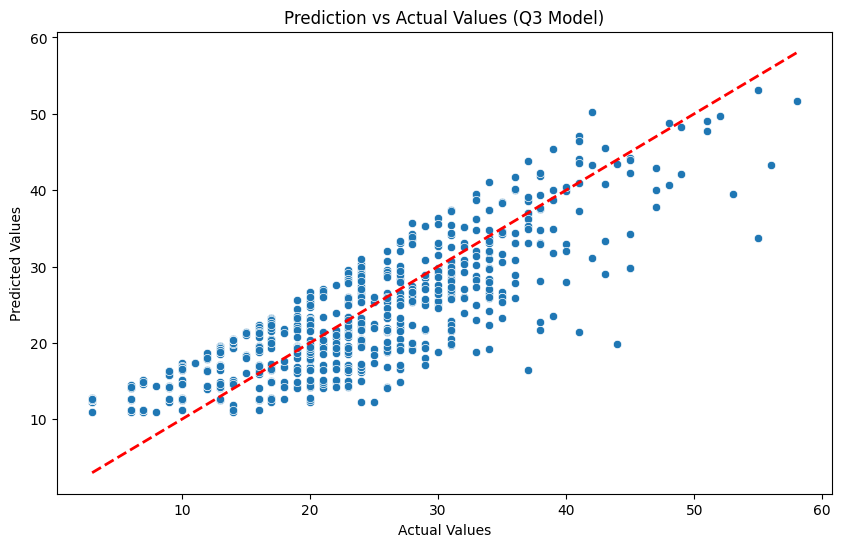

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

# Replace `predictions` with the dataset for Quarter 3
q3_data = predictions_glr_q3.select("prediction", "4").toPandas()
q3_data.rename(columns={"prediction": "Predicted", "4": "Actual"}, inplace=True)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=q2_data['Actual'], y=q3_data['Predicted'])
plt.plot(
    [q3_data['Actual'].min(), q3_data['Actual'].max()],
    [q3_data['Actual'].min(), q3_data['Actual'].max()],
    'r--', lw=2
)
plt.title('Prediction vs Actual Values (Q3 Model)')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

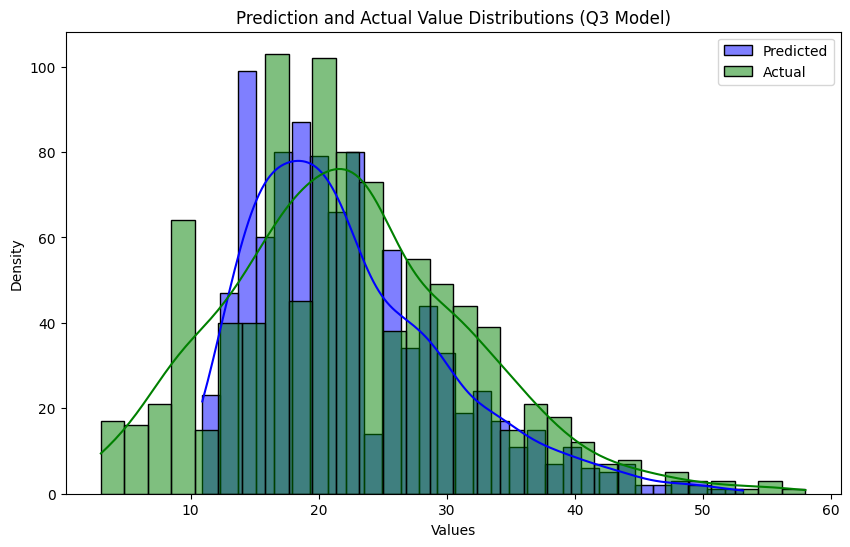

In [37]:
plt.figure(figsize=(10, 6))
sns.histplot(q3_data['Predicted'], kde=True, color='blue', label='Predicted', bins=30)
sns.histplot(q3_data['Actual'], kde=True, color='green', label='Actual', bins=30)
plt.title('Prediction and Actual Value Distributions (Q3 Model)')
plt.xlabel('Values')
plt.ylabel('Density')
plt.legend()
plt.show()

We can see the model has improved tremendously.  There still is a bias against very low point scoring teams, and we can see that slack is made up by having a higher density of 14ish point games, but the overall probability distribution has improved tremendously.

## Less successful versions of models

We tried making additional models to see if another variation would be a more suitable option.  Here are some examples of such slightly less successful alternatives tested.

In [38]:
''' Decision Tree Regressor Model for Q3 predictions '''

from pyspark.ml.regression import DecisionTreeRegressor

assembler = VectorAssembler(
    inputCols=[
         "1", "q2pts", "q3pts", "interaction_1_2", "interaction_2_3", "interaction_1_3", "Home"
    ],
    outputCol="features"
)
poly_expansion = PolynomialExpansion(inputCol="features", outputCol="poly_features", degree=2)

dt = DecisionTreeRegressor(featuresCol="scaled_features", labelCol="4", maxDepth=5)
pipeline_dt = Pipeline(stages=[assembler, poly_expansion, scaler, dt])
train_data, test_data = df_new.randomSplit([0.8, 0.2], seed=42)

model_dt = pipeline_dt.fit(train_data)
predictions_dt = model_dt.transform(test_data)

#Evaluate the model#
rmse_dt = evaluator.evaluate(predictions_dt)
print(f"Decision Tree RMSE: {rmse_dt}")

Decision Tree RMSE: 5.509186911012099


In [39]:
''' GBTRegressor Model for Q3 predictions '''

from pyspark.ml.regression import GBTRegressor

assembler = VectorAssembler(
    inputCols=[
         "1", "q2pts", "q3pts", "interaction_1_2", "interaction_2_3", "interaction_1_3", "Home"
    ],
    outputCol="features"
)
poly_expansion = PolynomialExpansion(inputCol="features", outputCol="poly_features", degree=2)
gbt = GBTRegressor(featuresCol="scaled_features", labelCol="4", maxIter=100, maxDepth=5)
pipeline_gbt = Pipeline(stages=[assembler, poly_expansion, scaler, gbt])

train_data, test_data = df_new.randomSplit([0.8, 0.2], seed=42)
model_gbt = pipeline_gbt.fit(train_data)
predictions_gbt = model_gbt.transform(test_data)

# evaluate the model
evaluator = RegressionEvaluator(labelCol="4", predictionCol="prediction", metricName="rmse")
rmse_gbt = evaluator.evaluate(predictions_gbt)
print(f"Gradient Boosted Trees RMSE: {rmse_gbt}")

Gradient Boosted Trees RMSE: 5.6506247358549455


# Score prediction based on performance metrics (with scoring)

This now combines in game metrics including team performance statistics and points scored

In [40]:
# using play by play data for this
path = '/content/drive/MyDrive/Cloud NFL/NFL Play by Play 2009-2018 (v5).csv'
df = spark.read.csv(path, header=True, inferSchema=True)

In [41]:
from pyspark.sql.functions import max, count, col, when, sum
from pyspark.sql import functions as F
from pyspark.sql.functions import lit
from pyspark.ml.feature import PolynomialExpansion, VectorAssembler, StandardScaler
from pyspark.ml.regression import GeneralizedLinearRegression
from pyspark.sql.functions import col, when
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline

In [42]:
# uses comparable play by play stats found in the weekly team stats

# home stats
home_stats = df.groupBy('game_id', 'posteam_type', 'qtr').agg(
    max('total_home_score').alias('score'),
    sum('yards_gained').alias('yards_gained'),
    sum('fumble').alias('fumble'),
    sum('shotgun').alias('shotgun'),
    sum('interception').alias('interception'),
    sum('rush_attempt').alias('rush_attempt'),
    sum('pass_attempt').alias('pass_attempt'))
# away stats
away_stats = df.groupBy('game_id', 'posteam_type', 'qtr').agg(
    max('total_away_score').alias('score'),
    sum('yards_gained').alias('yards_gained'),
    sum('fumble').alias('fumble'),
    sum('shotgun').alias('shotgun'),
    sum('interception').alias('interception'),
    sum('rush_attempt').alias('rush_attempt'),
    sum('pass_attempt').alias('pass_attempt'))

In [43]:
# removes rows of null values, fumble was chosen arbitrarily
hs_clean = home_stats.na.drop(subset=["fumble"])
as_clean = away_stats.na.drop(subset=["fumble"])

In [44]:
# creates pivots so each row is a game, and columns show the score and
# other metrics for each quarter

# home values
hs_pivot = (
    hs_clean.groupBy('game_id')
    .pivot("qtr", ['1','2','3','4'])  # Specify the unique values of 'time' if known
    .agg(
        F.first("score"),
        F.first("yards_gained"),
        F.first("fumble"),
        F.first("shotgun"),
        F.first("interception"),
        F.first("rush_attempt"),
        F.first("pass_attempt")
    )
)
# 1 represents home
hs_pivot = hs_pivot.withColumn("home", lit(1))

# away values
as_pivot = (
    hs_clean.groupBy('game_id')
    .pivot("qtr", ['1','2','3','4'])  # Specify the unique values of 'time' if known
    .agg(
        F.first("score"),
        F.first("yards_gained"),
        F.first("fumble"),
        F.first("shotgun"),
        F.first("interception"),
        F.first("rush_attempt"),
        F.first("pass_attempt")
    )
)
# 0 represents away
as_pivot = as_pivot.withColumn("home", lit(0))

In [45]:
# combine the files together
stats = hs_pivot.union(as_pivot)

In [46]:
# 1st quarter stats
stats_q1 = stats.select(
    col('home'),
    col('1_first(score)').alias('1'),
    col('4_first(score)').alias('4'),
    col('1_first(yards_gained)').alias('yards_gained'),
    col('1_first(fumble)').alias('fumble'),
    col('1_first(shotgun)').alias('shotgun'),
    col('1_first(interception)').alias('interception'),
    col('1_first(rush_attempt)').alias('rush_attempt'),
    col('1_first(pass_attempt)').alias('pass_attempt'),
)

In [47]:
# 2nd quarter stats
stats_q2 = stats.select(
    col('home'),
    col('1_first(score)').alias('1'),
    col('2_first(score)').alias('2'),
    col('4_first(score)').alias('4'),
    (col('1_first(yards_gained)') + col('2_first(yards_gained)')).alias('yards_gained'),
    (col('1_first(fumble)') + col('2_first(fumble)')).alias('fumble'),
    (col('1_first(shotgun)') + col('2_first(shotgun)')).alias('shotgun'),
    (col('1_first(interception)') + col('2_first(interception)')).alias('interception'),
    (col('1_first(rush_attempt)') + col('2_first(rush_attempt)')).alias('rush_attempt'),
    (col('1_first(pass_attempt)') + col('2_first(pass_attempt)')).alias('pass_attempt'),
)

In [48]:
# remove 0s so the model can run
# also works at removing outliers
stats_q1 = stats_q1.filter(col("4") > 0)

''' QUARTER 1 '''

assembler = VectorAssembler(
    inputCols=[
        "1", "home", "yards_gained", "fumble", "shotgun", "interception", "rush_attempt", "pass_attempt"
    ],
    outputCol="features"
)

poly_expansion = PolynomialExpansion(inputCol="features", outputCol="poly_features", degree=2)
scaler = StandardScaler(inputCol="poly_features", outputCol="scaled_features", withStd=True, withMean=False)
glr = GeneralizedLinearRegression(
    featuresCol="scaled_features",
    labelCol="4",
    family="gaussian",
    link="log",
    maxIter=50,         #Increase iterations for better convergence#
    regParam=0.1        #Add regularization to reduce overfitting#
)

pipeline_glr = Pipeline(stages=[assembler, poly_expansion, scaler, glr])
train_data, test_data = stats_q1.randomSplit([0.8, 0.2], seed=42)

model_glr_q1_comb = pipeline_glr.fit(train_data)
predictions_glr_q1_comb = model_glr_q1_comb.transform(test_data)

# Evaluate the model
evaluator = RegressionEvaluator(labelCol="4", predictionCol="prediction", metricName="rmse")
rmse_glr = evaluator.evaluate(predictions_glr_q1_comb)

print(f"Enhanced Generalized Linear Regression RMSE: {rmse_glr}")

Enhanced Generalized Linear Regression RMSE: 8.840339447630688


In [49]:
# removes 0s so the model can run, works as removing outliers
stats_q2 = stats_q2.filter(col("4") > 0)

# creates extra values to use
stats_q2 = stats_q2.withColumn("q2pts", col("2") - col("1"))
#stats_q2 = stats_q2.withColumn("weighted_1", col("1") * 0.5)
#stats_q2 = stats_q2.withColumn("weighted_2", col("2") * 1.0)
stats_q2 = stats_q2.withColumn("interaction_1_2", col("1") * col("2"))

''' QUARTER 2 '''

assembler = VectorAssembler(
    inputCols=[
        "1", "q2pts", "interaction_1_2", "home",
        "yards_gained", "fumble", "shotgun", "interception", "rush_attempt", "pass_attempt"
    ],
    outputCol="features"
)

poly_expansion = PolynomialExpansion(inputCol="features", outputCol="poly_features", degree=2)
scaler = StandardScaler(inputCol="poly_features", outputCol="scaled_features", withStd=True, withMean=False)
glr = GeneralizedLinearRegression(
    featuresCol="scaled_features",
    labelCol="4",
    family="gaussian",
    link="log",
    maxIter=50,         #Increase iterations for better convergence#
    regParam=0.1        #Add regularization to reduce overfitting#
)

pipeline_glr = Pipeline(stages=[assembler, poly_expansion, scaler, glr])
train_data, test_data = stats_q2.randomSplit([0.8, 0.2], seed=42)

model_glr_q2_comb = pipeline_glr.fit(train_data)
predictions_glr_q2_comb = model_glr_q2_comb.transform(test_data)

#Evaluate the Model
evaluator = RegressionEvaluator(labelCol="4", predictionCol="prediction", metricName="rmse")
rmse_glr = evaluator.evaluate(predictions_glr_q2_comb)

print(f"Enhanced Generalized Linear Regression RMSE: {rmse_glr}")

Enhanced Generalized Linear Regression RMSE: 7.0335273175582875


From what we can see from the RMSE, this uses more information, but has a worse result.  Since this extra information doesn't look to add any benefit (it looks like its making our model less accurate if anything), but could slow down the live analysis, we have decided to omit these the use of these models from our final deployment.

# Evaluating models on 2023 NFL season

Overview of how well our models would have predicted live results for the 2023 NFL season.  Code for these insights are found below.

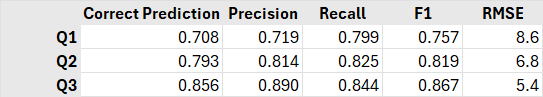

In [50]:
# read 2023 play by play data
path = '/content/drive/MyDrive/Cloud NFL/play_by_play_2023.csv'
testing = spark.read.csv(path, header=True, inferSchema=True)

## Preparing data for evaluation

### Format DF
This should look familiar

In [51]:
# reduces size of df to only have needed columns
pts2 = testing.select('game_id', 'home_team', 'away_team', 'game_date', 'qtr', 'total_home_score', 'total_away_score')
pts2.createOrReplaceTempView("NFL1")

In [52]:
# gets total score for each quarter

# home team total scores
quarters_23 = spark.sql("\
SELECT `game_id`, `qtr`, MAX(total_home_score) as score \
FROM NFL1 \
GROUP BY `game_id`, `qtr` \
")
# away team total scores
quarters_away_23 = spark.sql("\
SELECT `game_id`, `qtr`, MAX(total_away_score) as score \
FROM NFL1 \
GROUP BY `game_id`, `qtr` \
")

In [53]:
# pivots the quarter data so each row is a single game with columns of the score
# by each quarter

# home pivot
df_pivot_23 = (
    quarters_23.groupBy('game_id')
    .pivot("qtr", ['1','2','3','4'])  # Specify the unique values of 'time' if known
    .agg(F.first("score"))  # Aggregate by taking the first score for each 'time'
)
# away pivot
df_pivot_away_23 = (
    quarters_away_23.groupBy('game_id')
    .pivot("qtr", ['1','2','3','4'])  # Specify the unique values of 'time' if known
    .agg(F.first("score"))  # Aggregate by taking the first score for each 'time'
)

In [54]:
# create column "Home", home = 1, away = 0

from pyspark.sql.functions import lit
df_pivot_23 = df_pivot_23.withColumn("Home", lit(1))
df_pivot_away_23 = df_pivot_away_23.withColumn("Home", lit(0))

df_23 = df_pivot_23.union(df_pivot_away_23)

In [55]:
# making new feature columns

# creates weights for the scores
df_23 = df_23.withColumn("weighted_1", col("1") * 0.5)
df_23 = df_23.withColumn("weighted_2", col("2") * 1.0)
df_23 = df_23.withColumn("weighted_3", col("3") * 1.5)

# gets individual points scored in each quarter
df_23 = df_23.withColumn("q2pts", col("2") - col("1"))
df_23 = df_23.withColumn("q3pts", col("3") - col("2"))

# creates interaction effects
df_23 = df_23.withColumn("interaction_1_2", col("1") * col("2"))
df_23 = df_23.withColumn("interaction_2_3", col("2") * col("3"))
df_23 = df_23.withColumn("interaction_1_3", col("1") * col("3"))

## RMSE

The models performed really well in the 2023 season compared to the testing data, suggesting there wasn't strong biases from overfitting the data.  The best models were the original ones, not the alternatives.

### Quarter 1

In [56]:
# Evaluate Q1 model
pred_q1_23 = model_glr_q1.transform(df_23)

evaluator = RegressionEvaluator(labelCol="4", predictionCol="prediction", metricName="rmse")
rmse_glr = evaluator.evaluate(pred_q1_23)

print(f"Enhanced Generalized Linear Regression RMSE: {rmse_glr}")

Enhanced Generalized Linear Regression RMSE: 8.600611047953702


The model in our test data had a RMSE of 8.3, so this is pretty comparable.

### Quarter 2

In [57]:
# Evaluate Q2 model
pred_q2_23 = model_glr_q2.transform(df_23)

evaluator = RegressionEvaluator(labelCol="4", predictionCol="prediction", metricName="rmse")
rmse_glr = evaluator.evaluate(pred_q2_23)

print(f"Enhanced Generalized Linear Regression RMSE: {rmse_glr}")

Enhanced Generalized Linear Regression RMSE: 6.842274748940299


Our test data had the RMSE of 6.87, so this is very comparable.

In [58]:
# Evaluate alternative Q2 model
pred_q2_23_alt = model_glr_q2_alt.transform(df_23)

evaluator = RegressionEvaluator(labelCol="4", predictionCol="prediction", metricName="rmse")
rmse_glr = evaluator.evaluate(pred_q2_23_alt)

print(f"Enhanced Generalized Linear Regression RMSE: {rmse_glr}")

Enhanced Generalized Linear Regression RMSE: 6.933867778218957


Our test data has the RMSE of 6.89, so this is very comparable.

### Quarter 3

In [59]:
# Evaluate Q3 model
pred_q3_23 = model_glr_q3.transform(df_23)

evaluator = RegressionEvaluator(labelCol="4", predictionCol="prediction", metricName="rmse")
rmse_glr = evaluator.evaluate(pred_q3_23)

print(f"Enhanced Generalized Linear Regression RMSE: {rmse_glr}")

Enhanced Generalized Linear Regression RMSE: 5.427002057034389


Our testing data has an RMSE of 5.3, so this is comparable

In [60]:
# Evaluate alternative Q3 model
pred_q3_23_alt1 = model_glr_q3_alt1.transform(df_23)

evaluator = RegressionEvaluator(labelCol="4", predictionCol="prediction", metricName="rmse")
rmse_glr = evaluator.evaluate(pred_q3_23_alt1)

print(f"Enhanced Generalized Linear Regression RMSE: {rmse_glr}")

Enhanced Generalized Linear Regression RMSE: 5.66649958389523


Our testing data has an RMSE of 5.5, so this is comparable

In [61]:
# Evaluate alternative Q3 model
pred_q3_23_alt2 = model_glr_q3_alt2.transform(df_23)

evaluator = RegressionEvaluator(labelCol="4", predictionCol="prediction", metricName="rmse")
rmse_glr = evaluator.evaluate(pred_q3_23_alt2)

print(f"Enhanced Generalized Linear Regression RMSE: {rmse_glr}")

Enhanced Generalized Linear Regression RMSE: 5.604334054725009


Our testing data has an RMSE of 5.5, so this is comparable

## Win Percentages

Run following code if not done above

In [62]:
pred_q1_23 = model_glr_q1.transform(df_23)
pred_q2_23 = model_glr_q2.transform(df_23)
pred_q3_23 = model_glr_q3.transform(df_23)

In [63]:
from pyspark.sql.functions import col, collect_list, struct
from pyspark.sql import functions as F

### Q1

In [64]:
# select columns we care about
q1_scores = pred_q1_23.select("game_id", "Home", "4", "prediction")

# pivot so get values we need
q1_match = q1_scores.groupBy("game_id").pivot("Home", ["1", "0"]).agg(
    collect_list(struct("4", "prediction"))
  )

# resort everything. This way it lines up the way we want
# HA -> Home Actual Points
# HP -> Home Predicted Points
# AA -> Away Actaul Points
# AP -> Away Predicted Points
q1_match = q1_match.select(
    col("game_id"),
    col("1")[0].getField("4").alias("HA"),
    col("1")[0].getField("prediction").alias("HP"),
    col("0")[0].getField("4").alias("AA"),
    col("0")[0].getField("prediction").alias("AP")
)

In [65]:
# AW -> Actual Win (if >0, actual win for home team)
# PW -> Predicted Win (if >0, expected win for home team)
q1_match = q1_match.withColumn("AW", col("HA") - col("AA"))
q1_match = q1_match.withColumn("PW", col("HP") - col("AP"))

In [66]:
q1_result = q1_match.agg(
     F.sum(F.when((F.col("PW") > 0) & (F.col("AW") > 0), 1).otherwise(0)).alias("W,W"),
     F.sum(F.when((F.col("PW") > 0) & (F.col("AW") < 0), 1).otherwise(0)).alias("W,L"),
     F.sum(F.when((F.col("PW") < 0) & (F.col("AW") > 0), 1).otherwise(0)).alias("L,W"),
     F.sum(F.when((F.col("PW") < 0) & (F.col("AW") < 0), 1).otherwise(0)).alias("L,L"),
     F.sum(F.when(F.col("PW") == 0, 1).otherwise(0)).alias("PTie")
)
q1_result.show()

+---+---+---+---+----+
|W,W|W,L|L,W|L,L|PTie|
+---+---+---+---+----+
|123| 48| 31| 69|   0|
+---+---+---+---+----+



70.8% accuracy at predicting the game winner by end of Q1

Precision: 0.719

Recall: 0.814

F1: 0.890

### Q2

In [67]:
# select columns we care about
q2_scores = pred_q2_23.select("game_id","Home", "4", "prediction")

# pivot so get values we need
q2_match = q2_scores.groupBy("game_id").pivot("Home", ["1", "0"]).agg(
    collect_list(struct("4", "prediction"))
  )

# resort everything. This way it lines up the way we want
# HA -> Home Actual Points
# HP -> Home Predicted Points
# AA -> Away Actaul Points
# AP -> Away Predicted Points
q2_match = q2_match.select(
    col("game_id"),
    col("1")[0].getField("4").alias("HA"),
    col("1")[0].getField("prediction").alias("HP"),
    col("0")[0].getField("4").alias("AA"),
    col("0")[0].getField("prediction").alias("AP")
)

In [68]:
# AW -> Actual Win (if >0, actual win for home team)
# PW -> Predicted Win (if >0, expected win for home team)
q2_match = q2_match.withColumn("AW", col("HA") - col("AA"))
q2_match = q2_match.withColumn("PW", col("HP") - col("AP"))

In [69]:
q2_result = q2_match.agg(
     F.sum(F.when((F.col("PW") > 0) & (F.col("AW") > 0), 1).otherwise(0)).alias("W,W"),
     F.sum(F.when((F.col("PW") > 0) & (F.col("AW") < 0), 1).otherwise(0)).alias("W,L"),
     F.sum(F.when((F.col("PW") < 0) & (F.col("AW") > 0), 1).otherwise(0)).alias("L,W"),
     F.sum(F.when((F.col("PW") < 0) & (F.col("AW") < 0), 1).otherwise(0)).alias("L,L"),
     F.sum(F.when(F.col("PW") == 0, 1).otherwise(0)).alias("PTie")
)
q2_result.show()

+---+---+---+---+----+
|W,W|W,L|L,W|L,L|PTie|
+---+---+---+---+----+
|127| 29| 27| 88|   0|
+---+---+---+---+----+



79.3% accuracy at predicting game winner

Precision: 0.719

Recall: 0.825

F1: 0.819

### Q3

In [70]:
# select columns we care about
q3_scores = pred_q3_23.select("game_id","Home", "4", "prediction")

# pivot so get values we need
q3_match = q3_scores.groupBy("game_id").pivot("Home", ["1", "0"]).agg(
    collect_list(struct("4", "prediction"))
  )

# resort everything. This way it lines up the way we want
# HA -> Home Actual Points
# HP -> Home Predicted Points
# AA -> Away Actaul Points
# AP -> Away Predicted Points
q3_match = q3_match.select(
    col("game_id"),
    col("1")[0].getField("4").alias("HA"),
    col("1")[0].getField("prediction").alias("HP"),
    col("0")[0].getField("4").alias("AA"),
    col("0")[0].getField("prediction").alias("AP")
)

In [71]:
# AW -> Actual Win (if >0, actual win for home team)
# PW -> Predicted Win (if >0, expected win for home team)
q3_match = q3_match.withColumn("AW", col("HA") - col("AA"))
q3_match = q3_match.withColumn("PW", col("HP") - col("AP"))

In [72]:
q3_result = q3_match.agg(
     F.sum(F.when((F.col("PW") > 0) & (F.col("AW") > 0), 1).otherwise(0)).alias("W,W"),
     F.sum(F.when((F.col("PW") > 0) & (F.col("AW") < 0), 1).otherwise(0)).alias("W,L"),
     F.sum(F.when((F.col("PW") < 0) & (F.col("AW") > 0), 1).otherwise(0)).alias("L,W"),
     F.sum(F.when((F.col("PW") < 0) & (F.col("AW") < 0), 1).otherwise(0)).alias("L,L"),
     F.sum(F.when(F.col("PW") == 0, 1).otherwise(0)).alias("PTie")
)
q3_result.show()

+---+---+---+---+----+
|W,W|W,L|L,W|L,L|PTie|
+---+---+---+---+----+
|130| 16| 24|101|   0|
+---+---+---+---+----+



85.6% accuraccy at predicting game winner

Precision: 0.890

Recall: 0.844

F1: 0.867

## Visualizations of performance

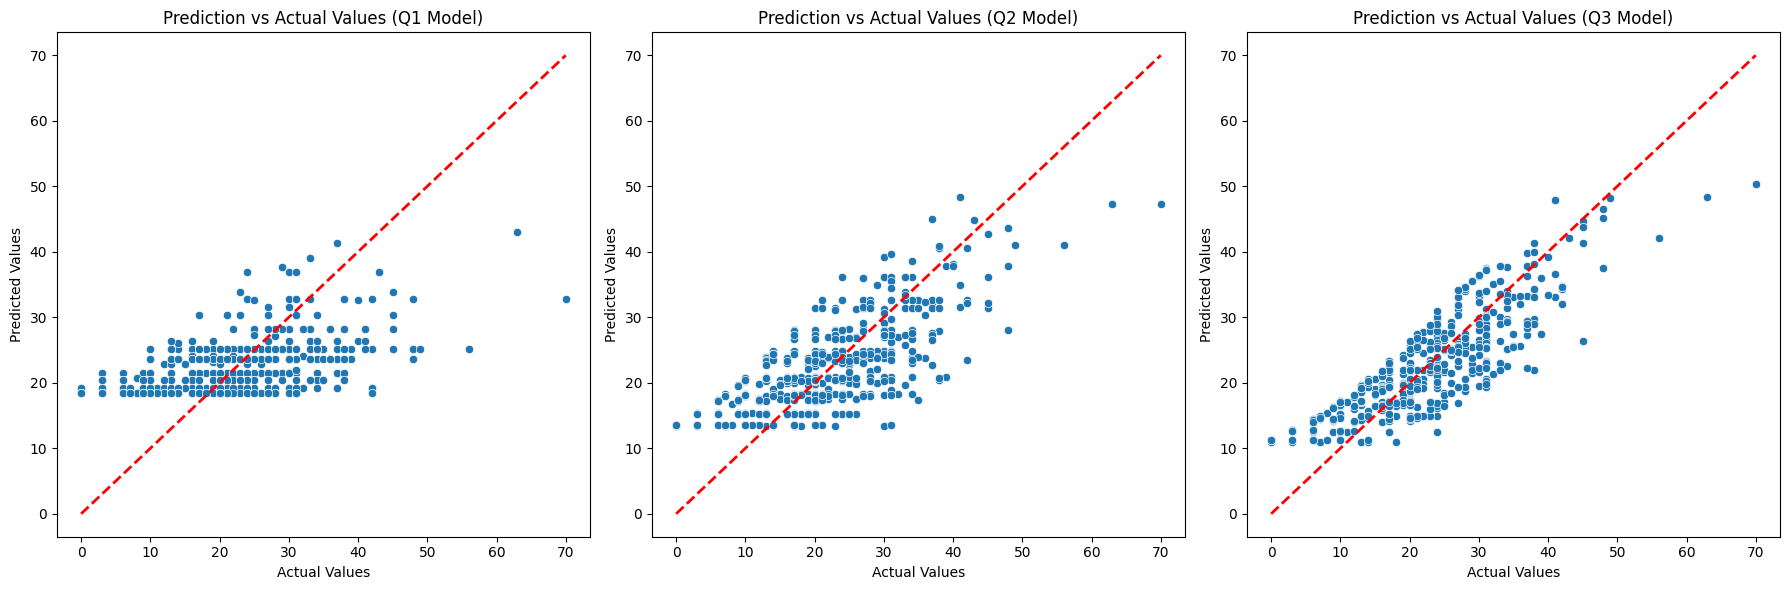

In [73]:
import matplotlib.pyplot as plt
import seaborn as sns

q3_data = pred_q3_23.select("prediction", "4").toPandas()
q3_data.rename(columns={"prediction": "Predicted", "4": "Actual"}, inplace=True)

q2_data = pred_q2_23.select("prediction", "4").toPandas()
q2_data.rename(columns={"prediction": "Predicted", "4": "Actual"}, inplace=True)

q1_data = pred_q1_23.select("prediction", "4").toPandas()
q1_data.rename(columns={"prediction": "Predicted", "4": "Actual"}, inplace=True)

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Q1 Model
sns.scatterplot(ax=axes[0], x=q1_data['Actual'], y=q1_data['Predicted'])
axes[0].plot(
    [q1_data['Actual'].min(), q1_data['Actual'].max()],
    [q1_data['Actual'].min(), q1_data['Actual'].max()],
    'r--', lw=2
)
axes[0].set_title('Prediction vs Actual Values (Q1 Model)')
axes[0].set_xlabel('Actual Values')
axes[0].set_ylabel('Predicted Values')

# Q2 Model
sns.scatterplot(ax=axes[1], x=q2_data['Actual'], y=q2_data['Predicted'])
axes[1].plot(
    [q2_data['Actual'].min(), q2_data['Actual'].max()],
    [q2_data['Actual'].min(), q2_data['Actual'].max()],
    'r--', lw=2
)
axes[1].set_title('Prediction vs Actual Values (Q2 Model)')
axes[1].set_xlabel('Actual Values')
axes[1].set_ylabel('Predicted Values')

# Q3 Model
sns.scatterplot(ax=axes[2], x=q3_data['Actual'], y=q3_data['Predicted'])
axes[2].plot(
    [q3_data['Actual'].min(), q3_data['Actual'].max()],
    [q3_data['Actual'].min(), q3_data['Actual'].max()],
    'r--', lw=2
)
axes[2].set_title('Prediction vs Actual Values (Q3 Model)')
axes[2].set_xlabel('Actual Values')
axes[2].set_ylabel('Predicted Values')

plt.tight_layout()
plt.show()

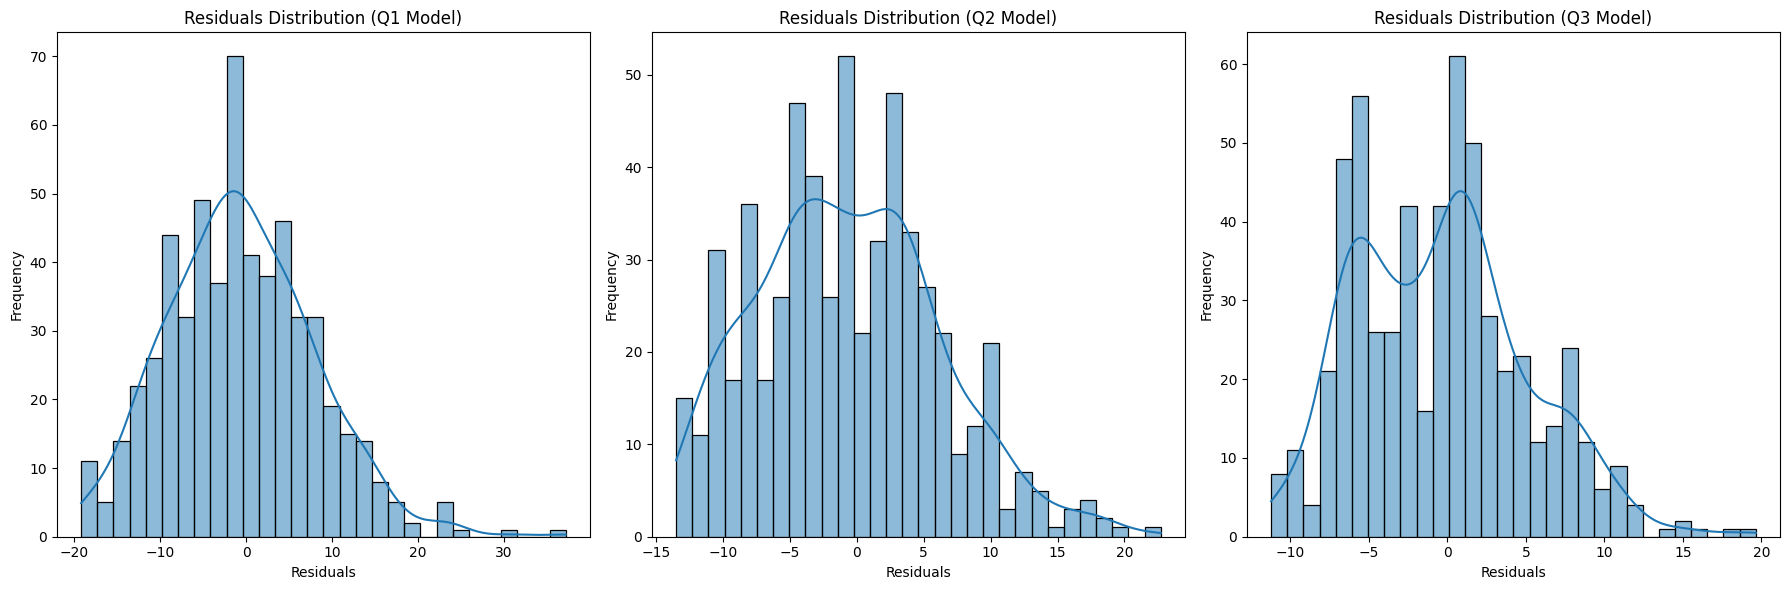

In [74]:
# uses same values as code from above
q3_data['Residuals'] = q3_data['Actual'] - q3_data['Predicted']
q2_data['Residuals'] = q2_data['Actual'] - q2_data['Predicted']
q1_data['Residuals'] = q1_data['Actual'] - q1_data['Predicted']

fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 3 columns

# Residual Distribution - Q1
sns.histplot(q1_data['Residuals'], kde=True, bins=30, ax=axes[0])
axes[0].set_title('Residuals Distribution (Q1 Model)')
axes[0].set_xlabel('Residuals')
axes[0].set_ylabel('Frequency')

# Residual Distribution - Q2
sns.histplot(q2_data['Residuals'], kde=True, bins=30, ax=axes[1])
axes[1].set_title('Residuals Distribution (Q2 Model)')
axes[1].set_xlabel('Residuals')
axes[1].set_ylabel('Frequency')

# Residual Distribution - Q3
sns.histplot(q3_data['Residuals'], kde=True, bins=30, ax=axes[2])
axes[2].set_title('Residuals Distribution (Q3 Model)')
axes[2].set_xlabel('Residuals')
axes[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

Interestingly, we start to see a bimodal distribution by the end of Q3, suggesting there there is a variable we haven't included in the model that would explain more of that variation.

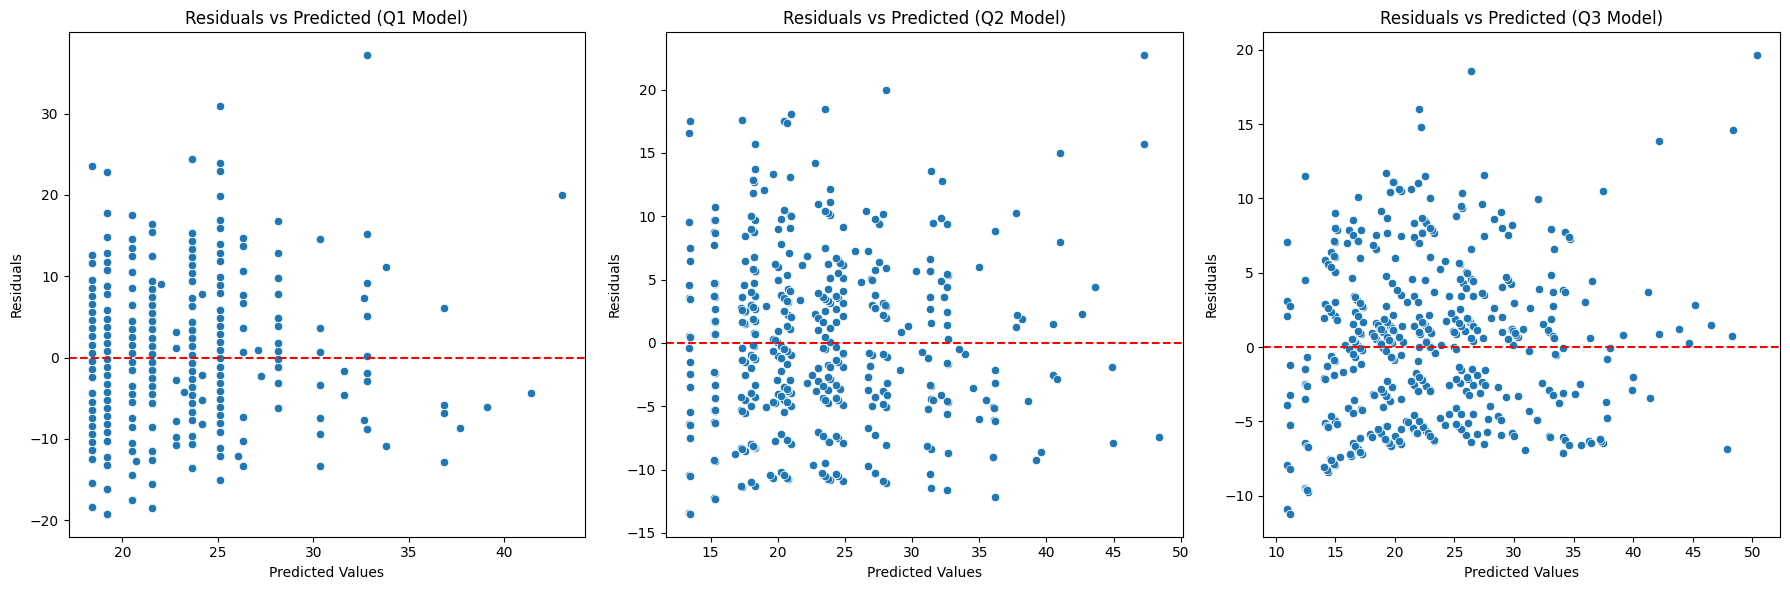

In [75]:
# uses same values as code from above
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 3 columns

# Residuals Q1
sns.scatterplot(x=q1_data['Predicted'], y=q1_data['Residuals'], ax=axes[0])
axes[0].axhline(0, color='red', linestyle='--')
axes[0].set_title('Residuals vs Predicted (Q1 Model)')
axes[0].set_xlabel('Predicted Values')
axes[0].set_ylabel('Residuals')

# Residuals Q2
sns.scatterplot(x=q2_data['Predicted'], y=q2_data['Residuals'], ax=axes[1])
axes[1].axhline(0, color='red', linestyle='--')
axes[1].set_title('Residuals vs Predicted (Q2 Model)')
axes[1].set_xlabel('Predicted Values')
axes[1].set_ylabel('Residuals')

# Residuals Q3
sns.scatterplot(x=q3_data['Predicted'], y=q3_data['Residuals'], ax=axes[2])
axes[2].axhline(0, color='red', linestyle='--')
axes[2].set_title('Residuals vs Predicted (Q3 Model)')
axes[2].set_xlabel('Predicted Values')
axes[2].set_ylabel('Residuals')

plt.tight_layout()
plt.show()

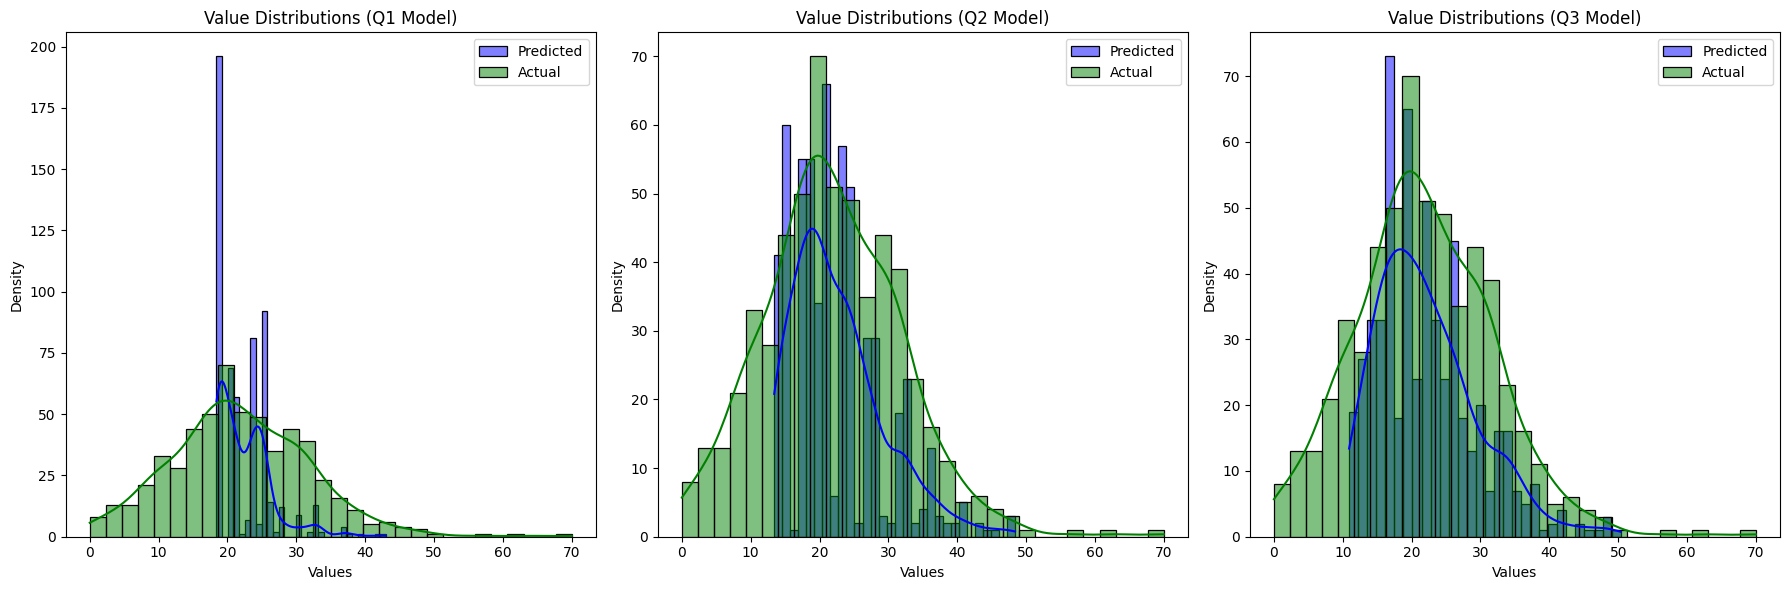

In [76]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 3 columns

# Q1 Model
sns.histplot(q1_data['Predicted'], kde=True, color='blue', label='Predicted', bins=30, ax=axes[0])
sns.histplot(q1_data['Actual'], kde=True, color='green', label='Actual', bins=30, ax=axes[0])
axes[0].set_title('Value Distributions (Q1 Model)')
axes[0].set_xlabel('Values')
axes[0].set_ylabel('Density')
axes[0].legend()

# Q2 Model
sns.histplot(q2_data['Predicted'], kde=True, color='blue', label='Predicted', bins=30, ax=axes[1])
sns.histplot(q2_data['Actual'], kde=True, color='green', label='Actual', bins=30, ax=axes[1])
axes[1].set_title('Value Distributions (Q2 Model)')
axes[1].set_xlabel('Values')
axes[1].set_ylabel('Density')
axes[1].legend()

# Q3 Model
sns.histplot(q3_data['Predicted'], kde=True, color='blue', label='Predicted', bins=30, ax=axes[2])
sns.histplot(q3_data['Actual'], kde=True, color='green', label='Actual', bins=30, ax=axes[2])
axes[2].set_title('Value Distributions (Q3 Model)')
axes[2].set_xlabel('Values')
axes[2].set_ylabel('Density')
axes[2].legend()

plt.tight_layout()
plt.show()

It looks like the significant improvements from the model come from Q1 to Q2, but the improvement heavily tapers off after halftime.